(This notebook was assembled in parts from an official [Pyro example](http://pyro.ai/examples/RSA-implicature.html) and [Chapter 1](http://www.problang.org/chapters/01-introduction.html) of the [Problang webbook](www.problang.org). 
The code is adapted from the Pyro example to fit the educational structure of the Problang chapter. I attempted to stay as close to the webbook as possible, but some minor alterations have been made, that hopefully stay true to the spirit of the Problang book. ~ Marvin

---

# Chapter 1: Language understanding as Bayesian inference

Much work in formal, compositional semantics follows the tradition of positing systematic but inflexible theories of meaning. However, in practice, the meaning we derive from language is heavily dependent on **nearly all aspects of context, both linguistic and situational**. To formally explain these nuanced aspects of meaning and better understand the compositional mechanism that delivers them, recent work in formal pragmatics recognizes semantics not as one of the final steps in meaning calculation, but rather as one of the first. Within the Bayesian **Rational Speech Act** framework ([Frank and Goodman, 2012](https://science.sciencemag.org/content/336/6084/998), **RSA**), **speakers** and **listeners** reason about each other’s reasoning about the literal interpretation of **utterances**. The resulting interpretation necessarily depends on the literal interpretation of an utterance, but is not necessarily wholly determined by it. This move — reasoning about likely interpretations — provides ready explanations for complex phenomena ranging from metaphor ([Kao et al., 2014](https://scholar.google.com/scholar?q=%22Formalizing%20the%20pragmatics%20of%20metaphor%20understanding%22)) and hyperbole ([Kao et al., 2014](http://www.pnas.org/content/111/33/12002)) to the specification of thresholds in degree semantics ([Lassiter and Goodman, 2013](http://journals.linguisticsociety.org/proceedings/index.php/SALT/article/view/2658)).

__Comment__: Research involving RSA is still alive and well, with new papers creating also more practical results such as a challenge-winning RSA-based Vision-and-Language Navigation agent ([Anderson et al. (2017)](https://arxiv.org/abs/1711.07280)), an efficient Multi-Agent RL framework (with a Benchmark on StarCraft II) ([Kang et al. (2020)](https://arxiv.org/abs/2006.04109)) and an information theoretic analysis and reframing of RSA ([Zaslavsky et al. (2020)](https://arxiv.org/abs/2005.06641)).

---

The **probabilistic pragmatics** approach leverages the tools of structured probabilistic models formalized in a **stochastic 𝞴-calculus** to develop and refine a **general theory of communication**. The framework synthesizes the knowledge and approaches from diverse areas — formal semantics, Bayesian models of inference, formal theories of measurement, philosophy of language, etc. — into an articulated theory of language in practice. These new tools yield broader empirical coverage and richer explanations for linguistic phenomena through the recognition of **language as a means of communication**, not merely a vacuum-sealed formal system. By subjecting the heretofore off-limits land of pragmatics to articulated formal models, the rapidly growing body of research both informs pragmatic phenomena and enriches theories of semantics. In what follows, we consider the first foray into this framework.

In [3]:
# first some imports
import torch # pyro is a thin wrapper library around torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

from collections import namedtuple

import argparse
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro_rsa_book_utils.search_inference import HashingMarginal, memoize, Search
from pyro_rsa_book_utils import silly_plotter

import warnings
warnings.filterwarnings("ignore")

We specify a helper function that wraps up inference. **Marginal** takes an un-normalized stochastic function, constructs the distribution over execution traces by using **Search**, and constructs the marginal distribution on return values (via **HashingMarginal**, which saves and compares **hashes** of the return values).

In [4]:
def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

This will allow us to write functions like so:

In [5]:
@Marginal
def func(arg1, arg2):
    r = ... # arbitrary internal code/control flow
    pyro.sample("example", dist.Categorical(torch.ones(2)/2)) # control flow may include Pyro's "sample" or "factor" statements
    return r

So that calls to ```func``` will yield a ```HashingMarginal``` distribution, whose support is all return values encountered during **Search**, and whose respective probabilities resulting from the stochasticity introduced by all ```pyro.sample``` and ```pyro.factor``` calls are saved by the **HashingMarginal** object.

For your solutions and/or better understanding, feel free to consult everything in ```pyro_rsa_book_utils```, especially ```silly_plotter```.

In [6]:
hashing_marginal_dist_for_func_given_args = func(0,1)
# print(dir(hashing_marginal_dist_for_func_given_args))
# hashing_marginal_dist_for_func_given_args?
# hashing_marginal_dist_for_func_given_args.log_prob?

Some useful pointers in the awesome explanatory [Pyro example notebooks](http://pyro.ai/examples/) are the intros to [Pyro models](http://pyro.ai/examples/intro_part_i.html), [Pyro Inference](http://pyro.ai/examples/intro_part_ii.html), and the [RSA examples](http://pyro.ai/examples/RSA-implicature.html).

---

# Introducing the Rational Speech Act framework

The Rational Speech Act (RSA) framework views communication as **recursive reasoning** between a speaker and a listener. **The listener** interprets the speaker’s utterance by reasoning about a **cooperative speaker** trying to inform a naive listener about some state of affairs. Using **Bayesian inference**, the listener reasons about what the **state of the world** is likely to be given that a speaker produced some **utterance**, knowing that the speaker is reasoning about how a listener is **most likely to interpret** that utterance. Thus, we have (at least) three levels of inference. At the top, the sophisticated, **pragmatic listener, $L_1$**
, reasons about the **pragmatic speaker, $S_1$**, and infers the **state of the world s** given that the speaker chose to produce the **utterance $u$**. The speaker chooses $u$ by maximizing the probability that a naive, **literal listener, $L_0$**, would correctly infer the **state of the world $s$** given the **literal meaning of $u$**.

To make this architecture more intelligible, let’s consider a concrete example and a vanilla version of an RSA model. In its initial formulation, [Frank and Goodman, 2012](https://science.sciencemag.org/content/336/6084/998) use the basic RSA framework to model **referent choice in efficient communication**. Let’s suppose that there are only three objects that the speaker and listener want to talk about, as in Fig. 1.

<img src='../../img/rsa_scene.png' width="400" height="400" align="middle">

_Fig 1_: Example referential communication scenario from [Frank and Goodman, 2012](https://science.sciencemag.org/content/336/6084/998). Speakers choose a single word, $u$, to signal an object, $s$.

---
In a reference game, a speaker wants to **refer to one of the given objects**. To simplify, we assume that the speaker may only choose one property (see below) with which to do so. In the example of _Fig. 1_, the set of world states

$S = \{blue-square, blue-circle, green-square\}$

contains the three objects given. The set of utterances

$U=\{``square",``circle",``green",``blue"\}$

contains the four properties from which the speaker can choose.

---

A vanilla RSA model for this scenario consists of three recursively layered, **conditional probability rules** for speaker production and listener interpretation. These rules are summarized in _Fig. 2_ and will be examined one-by-one below. The overal idea is that a pragmatic speaker $S_1$
chooses a word $u$ to best signal an object $s$ to a literal listener $L_0$, who interprets $u$ as true and finds the objects that are compatible with the meaning of $u$. The pragmatic listener $L_1$ reasons about the speaker’s reasoning and interprets $u$ accordingly, using **Bayes’ rule**; $L_1$ also weighs in the prior probability of objects in the scenario (i.e., an object’s salience, $P(s)$). By **formalizing the contributions of salience and efficiency**, the RSA framework provides an **information-theoretic definition of informativeness** in pragmatic inference.

* Pragmatic Listener: $P_{L_1}(s|u)\propto P_{S_1}(u|s)\cdot P(s)$
* Pragmatic Speaker: $P_{S_1}(u|s)\propto \exp(\alpha U_{S_1}(u;s)$
* Literal Listener: $P_{L_0}(s|u)\propto [[u]](s)\cdot P(s)$

_Fig. 2_: Schema of RSA reasoning hierarchy.

--- 
## 1. Literal Listener: $L_0$

At the base of this reasoning, the naive, literal listener $L_0$
**interprets an utterance according to its meaning**. That is, L0 computes the probability of s given u according to the semantics of u and the prior probability of s. A standard view of the semantic content of an utterance suffices: a mapping from states of the world to truth values. For example, the utterance "blue" is true of states blue-square and blue-circle and false of state green-square. We write **$[[u]]:S↦\{0,1\}$** for the denotation function of this standard, **Boolean semantics of utterances** in terms of states. The literal listener is then defined via a function **$P_{L_0}:U↦Δ^S$** that maps each utterance to a **probability distribution over world states $Δ^S$**, like so:

$$P_{L_0}(s∣u)∝[[u]](s)⋅P(s)$$

Here, $P(s)$ is an _a priori_ belief regarding which state or object the speaker is likely to refer to in general. These prior beliefs can capture general world knowledge, perceptual salience, or other things. For the time being, we assume a flat prior belief according to which each object is equally likely. (As we move away from flat priors, we’ll want to revise these assumptions so that $L_0$ (but not $L_1$!) uses a uniform prior over states. In fact, this is what [Frank and Goodman, 2012](https://science.sciencemag.org/content/336/6084/998) assumed in their model. See Appendix Chapter 4 for discussion.)

The literal listener rule can be implemented as follows in _Pyro_:

In [7]:
Object = namedtuple("Object", ("color", "shape", "string"))
_obj = lambda color, shape: Object(color, shape, " ".join([color, shape])) 

# Set of states as in Fig. 1 (here: objects of reference).
# We represent Objects as namedtuples to disambiguate them from utterances
# Internally Objects are still treated as strings.
objects = [
    _obj("blue", "square"),
    _obj("blue", "circle"),
    _obj("green", "square")
]

# uniform distribution over world states
def object_prior():
    prior_dist = dist.Categorical(probs=torch.ones(len(objects))/len(objects))
    idx = pyro.sample("object", prior_dist)
    return objects[idx]

# set of utterances (all property values, in this case)
utterances = ["blue", "green", "square", "circle"]

# literal meaning function [[u]](s) to interpret the utterances
meaning = lambda utterance, obj: utterance in obj.string

@Marginal # <- makes function call run an exhaustive search over all (stochastic) pyro.sample/.factor/.. calls to get an accurate "marginal" dist over return values 
def literal_listener(utterance):
    obj = object_prior()
    # values below are log probabilities
    pyro.factor("literal_meaning", 0. if meaning(utterance, obj) else -999999.)
    return obj

Let's run this!

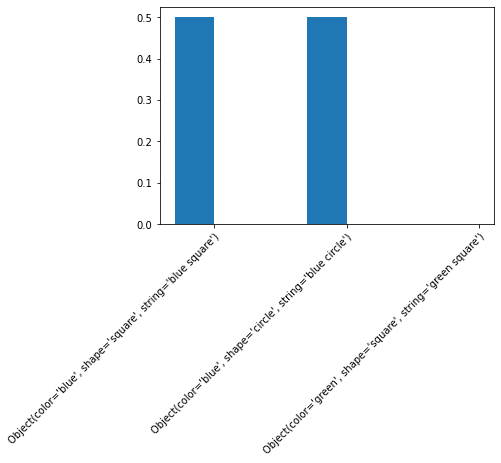

In [8]:
utterance = "blue"
marginal_l0_dist = literal_listener(utterance)
silly_plotter(marginal_l0_dist)

## Exercises 1

1. In the model above, ```objectPrior()``` returns a sample from a uniform```Categorical``` distribution over the possible objects of reference. What happens when the listener's beliefs are not uniform over the possible objects of reference (e.g., the "green square" is very salient)?
0. What happens for other values of ```utterance```?
2. Write down the full Bayes Rule for $L_0$. Annotate it with the terms _likelihood_, _prior_, _marginal_, and _posterior_. Where, if at all, does $[[u]](s)$ appear?
3. Compare your solution to _Ex. 1.2_ to the $L_0$ equation above: Why does the equation say $\propto$? (Hint: Think about the **decision** $L_0$ makes after calculating the histogram above. Formulate this decision mathematically if needed.)
4. What do ```pyro.sample``` and ```pyro.factor``` do, respectively? Consult the [_Pyro_ Docs](https://docs.pyro.ai/en/stable/primitives.html?highlight=factor#pyro.primitives.factor) (These, along with ```pyro.param``` are the three most basic _Pyro_ functions, which are called _primitives_)).
5. Write down the mathematical notation for the variables ```literal_listener``` and ```marginal_l0_dist```. What is the difference?

Fantastic! We now have a way of integrating a listener’s prior beliefs about the world with the truth functional meaning of an utterance.

---

## 2. Pragmatic Listener $S_1$
_Speech acts_ are actions; thus, the speaker is modeled as a rational (**Bayesian**) actor. He chooses an action (e.g., an utterance) according to its **utility**. The speaker **simulates** taking an action, evaluates its utility, and chooses actions based on their utility. Rationality of choice is often defined as choice of an action that **maximizes** the agent’s (expected) utility. Here we consider a generalization in which speakers use a **softmax function** to approximate the (classical) rational choice to a variable degree. (For more on action as inverse planning, see [www.agentmodels.org](www.agentmodels.org).)

### Bayesian decision-making

In the code box below, you’ll see a generic **approximately rational** agent model. In rough terms, what happens is this: Each ``` pyro.factor``` statement increments the logarithm of the probability (```log_prob```,) of the argument to be evaluated. These evaluations happen many times: For one call of ```agent(...)```,
__Monte Carlo__ is run (in this case, exhaustively), and a distribution of return values is created.

For example, when the **HashingMarginal** resulting from the call to the _decorated_ ```agent``` considers the probabilities of the three actions in the example below (by enumeration), it first calculates a ```log_prob``` for each action (e.g., by evaluating the factor statement and considering the fact that each action is a draw from a uniform distribution), and then computes normalized probabilities from these. In effect, the function agent therefore computes the distribution:

$$P(a_i) = \frac{\exp(\alpha\cdot U(a_i))}{\sum_j\exp(\alpha\cdot U(a_j))}$$
Here, $\alpha$ is also called optimality parameter, or temperature. The above **Softmax** distribution frequently occurs in the output layer of Neural Sequence-to-Sequence Models.

In [11]:
# aside on bayesian decision making

# define action space
actions = ["a1", "a2", "a3"]

# define uniform prior over actions
def action_prior():
    action_dist = dist.Categorical(probs=torch.ones(len(actions))/len(actions))
    action = pyro.sample("action", action_dist)
    return action

# define utilities for the actions
def utility(tensor_action_idx):
    action = actions[int(tensor_action_idx.item())]
    lookup_table = {
        "a1": 1.,
        "a2": 2.,
        "a3": 3.
    }
    return lookup_table[action]

# define actor optimality
alpha = 1

# define rational agent who chooses actions
# according to their expected utility
@Marginal
def agent():
    action = action_prior()
    pyro.factor("utility", alpha * utility(action))
    return action

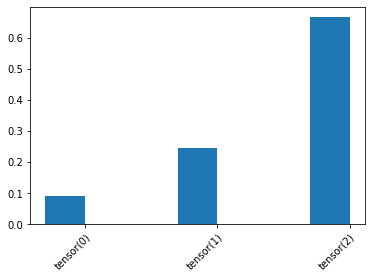

In [15]:
agent_dist = agent() # TODO FIXME
silly_plotter(agent_dist)

## Exercises 2 a)
1. Check to make sure ```utility()``` returns the correct value for $a_3$.
2. Explore what happens when you change the actor's optimality.
3. Explore what happens when you change the utilities.

---

### A rational speech actor

In language understanding, the **utility of an utterance** is how well it communicates the state of the world $s$ to a listener. So, the speaker $S_1$ chooses utterances $u$ to communicate the state $s$ to the hypothesized literal listener $L_0$. Another way to think about this: $S_1$ wants to **minimize the effort $L_0$ would need** to arrive at $s$ from $u$, all **while being efficient at communicating**. $S_1$ thus seeks to minimize the surprisal of $s$ given $u$ for the literal listener $L_0$, while bearing in mind the **utterance cost, $C(u)$**. (This trade-off between efficacy and efficiency is not trivial: speakers could always use minimal ambiguity, but unambiguous utterances tend toward the unwieldy, and, very often, unnecessary. We will see this tension play out later in the book.)

Speakers act in accordance with the speaker’s utility function $U_{S_1}$: utterances are more useful at communicating about some state as surprisal and utterance cost decrease. (See the Appendix Chapter 2 for more on speaker utilities.)

$$U_{S_1}(u;s) = \log L_0(s|u) - C(u)$$

## Exercise 2 b)
1. Go to the literal listener code box above _Ex. 1_ and find $\log L_0(s|u=``blue``)$ for each reference object $s$.

---

With this utility function in mind, $S_1$ computes the probability of an utterance $u$ given some state $s$ in proportion to the speaker's utility function $U_{S_1}$. The term $\alpha > 0$ controls the speaker's optimality, i.e. the speaker's **rationality** in choosing utterances. We define

$$P_{S_1}(u|s)\propto\exp(\alpha\cdot U_{S_1}(u;s)),$$
which expands to

$$P_{S_1}(u|s)\propto\exp(\alpha(\log L_0(s|u)-C(u)$$

The following code implements this model of the speaker:

In [ ]:
# your code here


# pragmatic speaker
@Marginal
def speaker(obj):
    utterance = utterance_prior()
    pyro.factor("speaker", s1_alpha * literal_listener(utterance).log_prob(obj) - cost(utterance))
    return utterance

In [ ]:
idx = ...
speaker(objects[idx])

## Exercise 2 c)
1. Visualise the speaker`s behavior for a blue square. You will have to define all of the variables referenced by ```speaker``` appropriately. You could make reasonable choices for $\alpha$ and $C(\cdot)$, or experiment. It should be enough to keep all distributions uniform for a start. 

---

## 3. Pragmatic Listener $L_1$


The pragmatic listener $L_1$
computes the probability of a state $s$ given some utterance $u$. By reasoning about the speaker $S_1$, this probability is proportional to the probability that $S_1$ would choose to utter $u$ to communicate about the state $s$, together with the prior probability of $s$ itself. In other words, to interpret an utterance, the pragmatic listener **considers the process that generated the utterance** in the first place.

$$P_{L_1}(s|u)\propto P_{S_1}(u|s)\cdot P(s)$$

In [19]:
@Marginal
def pragmatic_listener(utterance):
    # your code here
    obj = pyro.sample("l1_simulation_of_speaker", speaker_dist, obs=utterance)
    return obj

In [21]:
utt = "blue"
l1_dist = pragmatic_listener(utt)
silly_plotter(l1_dist)

## Exercise 3
1. Implement the ```pragmatic_listener```.
2. Visualize its interpretations of various utterances.
---

Awesome, that´s it. Weve reached the top of the vanilla RSA inference hierarchy, so pat yourself on the back for making it this far. 

Alright, let´s quickly throw it all together again for some more exercises.

## 4. Putting it all together

In [ ]:
# TODO copy everything from above

## Exercise 3: 
1. Explore what happens if you make the speaker _more_ optimal.
2. Add another object to the scenario.
3. Add a new multi-word utterance.
4. Check the behavior of the other possible utterances.
5. Is there any way to get ``blue`` to refer to something green? Why or why not?
6. Think about implicit assumptions in this model regarding what speaker and listener know about one another (You could make a table with distributions and parameters, who they ```belong``` to, and who, out of speaker and listener, has access to them). How would you address this, i.e. think of a speaker and listener that do not have access to each other. What additional problems would you expect in this case? (For further discussion, see _Sec. 4.3_ in [Kang et al. (2020)](https://arxiv.org/abs/2006.04109).)

Happy coding :)